# The Attention Mechanism
The self-attention mechanism addresses the limitations found in CNNs and RNNs such as vanishing gradients and limited context by allowing each word in the sequence to attend to all other words, capturing long-range dependencies efficiently.

* Create 3 copies of the input tensor representing the query, key, and value. Shape (batch_size, seq_len, d_model).
* Multiply the query, key, and value tensors with their respective weight matrices to obtain the query, key, and value projections.
  * Shape (batch_size, seq_len, d_model).
* Multiply the query and key tensors together to obtain the dot product similarity scores.
  * Shape (batch_size, seq_len, seq_len).
* Scale the similarity scores by dividing them by the square root of the dimension of the key vectors.
* Multiply the scaled similarity scores with the value tensor to obtain the self-attention output.
* Softmax the self-attention output along the sequence dimension to obtain the attention weights.
  * Shape (batch_size, seq_len, d_model).

What do Query, Key, and Value mean?
* Query: The word for which we are calculating the attention.
* Key: The word which we are comparing the query to.
* Value: The word which we are going to output.

Overall, the self attention assesses the importance of each word in the sequence with respect to the query word. The attention scores are then used to weigh the value vectors, which are then summed to obtain the self-attention output.



References:

https://www.youtube.com/watch?v=Mn_9W1nCFLo

https://www.youtube.com/watch?v=oM4VmoabDAI

[Attention is All You Need, Vaswani et al. 2017](https://arxiv.org/abs/1706.03762)
[Fast Transformer Decoding: One Write-Head is All You Need](https://arxiv.org/abs/1911.02150)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
torch.manual_seed(0)
sample_input = torch.rand(1, 10, 512) # (Batch, Seq_len, d_model)
sample_input

tensor([[[0.4963, 0.7682, 0.0885,  ..., 0.6673, 0.3561, 0.8091],
         [0.3613, 0.3136, 0.6259,  ..., 0.1876, 0.2099, 0.7210],
         [0.4650, 0.0278, 0.2117,  ..., 0.5025, 0.4458, 0.2083],
         ...,
         [0.1100, 0.0771, 0.6113,  ..., 0.7174, 0.6193, 0.0636],
         [0.8637, 0.4471, 0.2902,  ..., 0.9446, 0.1363, 0.9336],
         [0.9479, 0.9039, 0.5435,  ..., 0.6666, 0.7545, 0.5523]]])

# Building Multi Head Attention Layer with Detail


## Multi Head Attention
Generally what the multi head attention layer does is:

* Split the Attention projections (query, key, and value) into, h, number of heads. Shape (batch_size, num_heads, seq_len, d_model / num_heads).
  * Each split is done along the embedding dimension, not the sequence dimension to allow each head to attend to a different part of the sequence.
  * This allows the attention head to access the full sentence, though only a portion of the embedding of each word. (word embeddings)
  * Essentially, every head is looking at the full sequence, but only a portion of the embedding of each word (d_model / num_heads).
* Apply the scaled dot product attention on each head. Shape (batch_size, num_heads, seq_len, d_model / num_heads).
* Concatenate the attention head outputs. Shape (batch_size, seq_len, d_model).
* Multiply the concatenated tensor with the output weight matrix to obtain the multi-head attention output. Shape (batch_size, seq_len, d_model).

* Example:
  d_model = 512, num_heads = 8, seq_len = 512

  * Input: "I love programming" (batch, seq, d_model) 
    * size = (1, 3, 512) 
  * Attention Projections: (batch_size, seq, d_model) -> (batch_size, seq_len, d_model)
    * size = (1, 3, 512) -> (1, 3, 512)
  * Split: (batch_size, seq_len, d_model) -> (batch_size, num_heads, seq_len, d_model / num_heads)
    * size = (1, 3, 512) -> (1, 8, 3, 64)
  * Multi Head Attention Output: (batch_size, num_heads, seq_len, d_model / num_heads) -> (batch_size, seq_len, d_model)
    * size = (1, 8, 3, 64) -> (1, 3, 512)

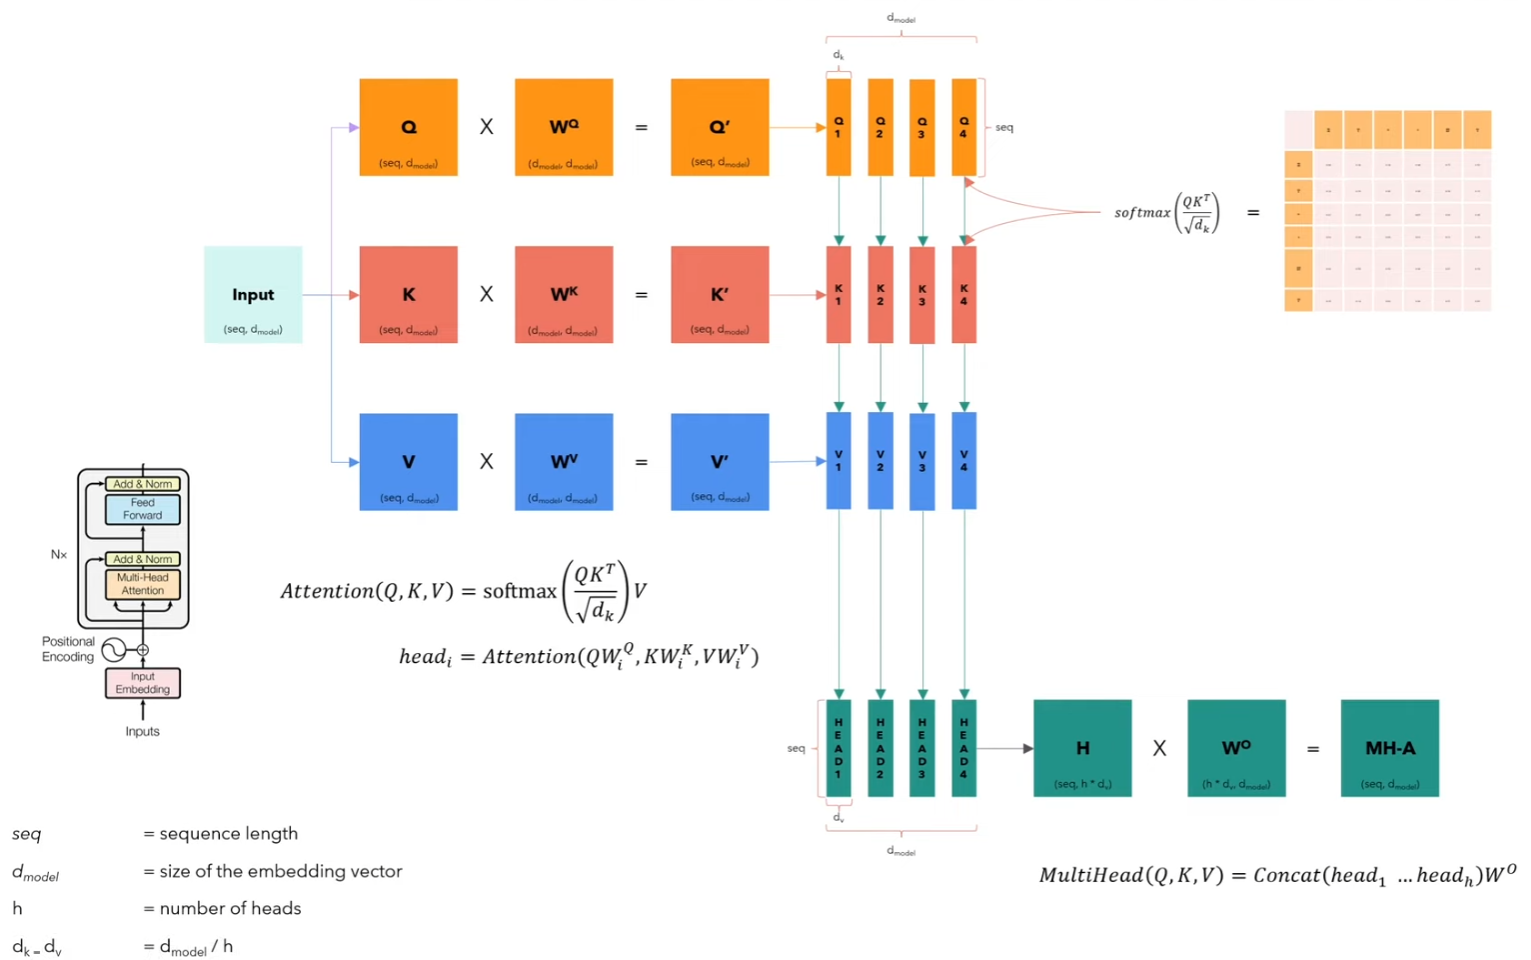



In [ ]:
class MultiHeadAttentionBlock(nn.Module):
    def __init__(self, embed_dim: int = 512, num_heads: int = 8, attn_dropout: float = 0.1, ff_dropout: float = 0.1,):
        super().__init__()
        self.num_heads = num_heads
        self.embed_dim = embed_dim
        assert embed_dim % self.num_heads == 0, "invalid heads and embedding dimension configuration"
        self.query = nn.Linear(embed_dim, embed_dim)
        self.key = nn.Linear(embed_dim, embed_dim)
        self.value = nn.Linear(embed_dim, embed_dim)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.attn_dropout = nn.Dropout(attn_dropout)
        self.proj_dropout = nn.Dropout(ff_dropout)
    
    def forward(self, x, mask=None):
        batch_size, seq_len, _ = x.size()
        # Apply linear transformations to the input tensor
        # Take input tensor and apply linear transformation,
        # then split the tensor into num_heads and head_dim
        # transpose the tensor into correct order
        # Shape: (batch_size, seq_len, embed_dim) -> (batch_size, seq_len, num_heads, head_dim) ->
        # (batch_size, seq_len, num_heads, head_dim) -> (batch_size, num_heads, seq_len, head_dim)
        q = self.query(x).view(batch_size, seq_len, self.num_heads, -1).transpose(1, 2)
        k = self.key(x).view(batch_size, seq_len, self.num_heads, -1).transpose(1, 2)
        v = self.value(x).view(batch_size, seq_len, self.num_heads, -1).transpose(1, 2)

        # Compute attention scores using Einsum
        # b: batch size, h: num_heads, i: seq_len, j: seq_len, d: head_dim
        # Multiply query and key tensors element-wise and sum along the shared dimension (head_dim)
        # Divide by the square root of the dimension of the query/key vectors
        # Equivalent to: attention = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(q.size(-1))
        # Shape: (batch_size, num_heads, seq_len, head_dim) * (batch_size, num_heads, seq_len, head_dim)
        # -> (batch_size, num_heads, seq_len, seq_len)
        attention = torch.einsum('bhid,bhjd->bhij', q, k) / torch.sqrt(torch.tensor(q.size(-1)).float())
        
        # Apply mask if provided
        if mask is not None:
            attention = attention.masked_fill(mask == 0, float("-inf"))
        
        # Apply softmax and dropout
        # Shape: (batch_size, num_heads, seq_len, seq_len) -> (batch_size, num_heads, seq_len, head_dim)
        attention = self.attn_dropout(F.softmax(attention, dim=-1))
        
        # Compute the weighted sum of values using attention scores
        # Equivalent to: torch.matmul(attention, v)
        # Shape: (batch_size, num_heads, seq_len, seq_len) * (batch_size, num_heads, seq_len, head_dim)
        # -> (batch_size, num_heads, seq_len, head_dim)
        attended_output = torch.matmul(attention, v)

        # Merge the num_heads and head_dim back to the embed_dim
        # Transpose sequence length and num_heads
        # Flatten out the full tensor
        # Reshape based on batch size, sequence length and embed_dim
        # Shape: (batch_size, num_heads, seq_len, head_dim) -> (batch_size, seq_len, num_heads, head_dim)
        # -> (batch_size, seq_len, num_heads * head_dim)
        # -> (batch_size, seq_len, embed_dim)
        output = attended_output.transpose(1, 2).contiguous().view(batch_size, seq_len, -1)

        # Apply linear transformation and dropout
        # Shape: (batch_size, seq_len, embed_dim) -> (batch_size, seq_len, embed_dim)
        return self.proj_dropout(self.proj(output))

In [ ]:
multi_head_attention_block = MultiHeadAttentionBlock()
multi_head_attention_block_output = multi_head_attention_block(sample_input)
multi_head_attention_block_output

# Multi Head Attention Simplified

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim: int = 512, num_heads: int = 8, attn_dropout: float = 0.1, ff_dropout: float = 0.1,):
        super().__init__()
        self.num_heads = num_heads
        self.embed_dim = embed_dim
        assert embed_dim % self.num_heads == 0, "invalid heads and embedding dimension configuration"
        self.query = nn.Linear(embed_dim, embed_dim)
        self.key = nn.Linear(embed_dim, embed_dim)
        self.value = nn.Linear(embed_dim, embed_dim)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.attn_dropout = nn.Dropout(attn_dropout)
        self.proj_dropout = nn.Dropout(ff_dropout)
    
    def forward(self, x, mask=None):
        batch_size, seq_len, _ = x.size()
        # Apply linear transformations to the input tensor
        q = self.query(x).view(batch_size, seq_len, self.num_heads, -1).transpose(1, 2)
        k = self.key(x).view(batch_size, seq_len, self.num_heads, -1).transpose(1, 2)
        v = self.value(x).view(batch_size, seq_len, self.num_heads, -1).transpose(1, 2)

        # Compute attention scores using Einsum
        attention = torch.einsum('bhid,bhjd->bhij', q, k) / torch.sqrt(torch.tensor(q.size(-1)).float())
        
        # Apply mask if provided
        if mask is not None:
            attention = attention.masked_fill(mask == 0, float("-inf"))
        
        # Apply softmax and dropout
        attention = self.attn_dropout(F.softmax(attention, dim=-1))
        
        # Compute the weighted sum of values using attention scores
        attended_output = torch.matmul(attention, v)

        # Merge the num_heads and head_dim back to the embed_dim
        output = attended_output.transpose(1, 2).contiguous().view(batch_size, seq_len, -1)

        # Apply linear transformation and dropout
        return self.proj_dropout(self.proj(output))

In [ ]:
multi_head_attention = MultiHeadAttention()
multi_head_attention_output = multi_head_attention(sample_input)
multi_head_attention_output

# Multi-Query Attention

We remove the head dimension from the K and V tensors and keep the head dimension in the Q tensor. This allows each head to attend to a different part of the sequence, but all heads share the same K and V tensors. This is known as multi-query attention.

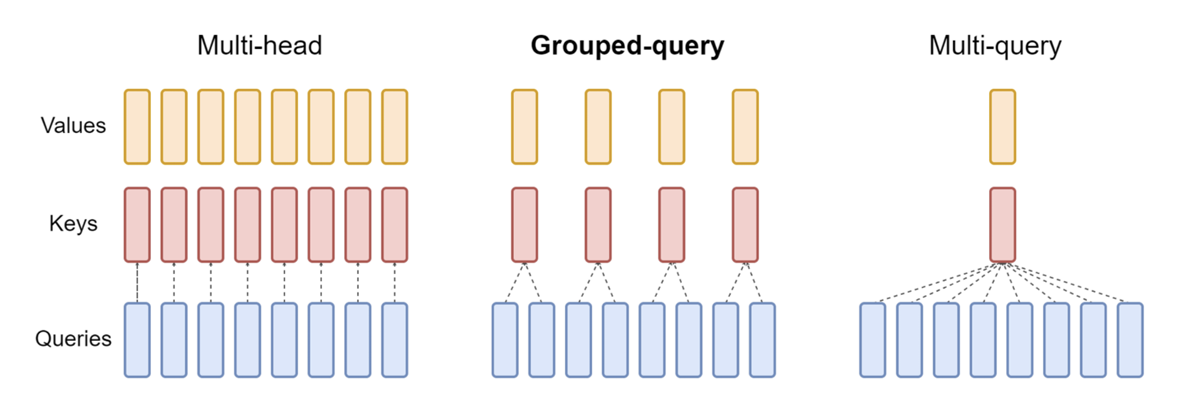

In [12]:
class MultiQueryAttention(nn.Module):
    def __init__(self, embed_dim: int = 512, num_heads: int = 8, attn_dropout: float = 0.1, ff_dropout: float = 0.1,):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        assert embed_dim % self.num_heads == 0, "invalid heads and embedding dimension configuration"

        # Linear transformations
        self.queries = nn.ModuleList([nn.Linear(embed_dim, embed_dim, bias=False) for _ in range(num_heads)])
        self.key = nn.Linear(embed_dim, embed_dim, bias=False)
        self.value = nn.Linear(embed_dim, embed_dim, bias=False)
        self.fc_outs = nn.ModuleList([nn.Linear(embed_dim, embed_dim) for _ in range(num_heads)])

        # Dropout layers
        self.attn_dropout = nn.Dropout(attn_dropout)
        self.proj_dropout = nn.Dropout(ff_dropout)
    
    def forward(self, x, mask=None):
        batch_size, seq_len, _ = x.size()
        # Apply linear transformations to the input tensor
        k = self.key(x) # Shape: (batch_size, seq_len, head_dim)
        v = self.value(x) # Shape: (batch_size, seq_len, head_dim)

        outputs = []
        for i, query_layer in enumerate(self.queries):
            q = query_layer(x)

            # Compute attention scores using Einsum
            attention = torch.einsum("nqd,nkd->nqk", q, k)  # Dot product

            # Apply mask if provided
            if mask is not None:
                attention = attention.masked_fill(mask == 0, float("-inf"))
        
            # Apply softmax and dropout
            attention = self.attn_dropout(F.softmax(attention / (self.embed_dim ** 0.5), dim=-1))

            # Compute the weighted sum of values using attention scores
            attention_output = torch.einsum("nqk,nkd->nqd", attention, v)  # Weighted sum

            # Project the output
            outputs.append(self.fc_outs[i](attention_output))

        # Stack the outputs and apply dropout
        # shape: (batch_size, seq_len, embed_dim, num_heads) -> (batch_size, seq_len, embed_dim)
        output = self.proj_dropout(torch.stack(outputs, dim=-1).mean(dim=-1))
        
        return output

In [13]:
multi_query_attention = MultiQueryAttention()
multi_query_attention_output = multi_query_attention(sample_input)
multi_query_attention_output.shape

torch.Size([1, 10, 512])

# Group Query Attention

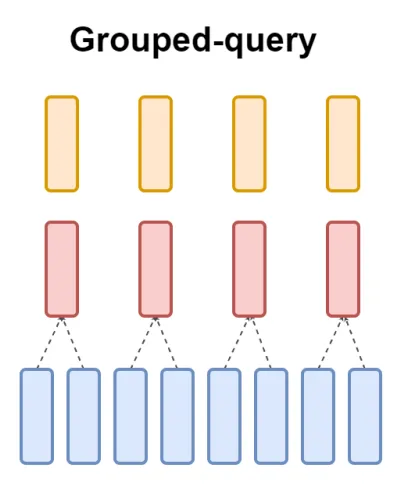

In [5]:
class GroupQueryAttention(nn.Module):
    def __init__(self, embed_dim: int = 512, n_heads: int = 8, kv_heads:int = None, attn_dropout: float = 0.1, ff_dropout: float = 0.1,):
        super().__init__()
        self.n_heads = n_heads
        self.embed_dim = embed_dim
        self.head_dim = embed_dim // n_heads
        self.num_kv_heads = kv_heads if kv_heads is not None else n_heads
        assert embed_dim % n_heads == 0, "invalid heads and embedding dimension configuration"
        self.query = nn.Linear(embed_dim, embed_dim, bias=False)
        self.key = nn.Linear(embed_dim, kv_heads * self.head_dim, bias=False)
        self.value = nn.Linear(embed_dim, kv_heads * self.head_dim, bias=False)
        self.proj = nn.Linear(embed_dim, embed_dim, bias=False)
        self.attn_dropout = nn.Dropout(attn_dropout)
        self.proj_dropout = nn.Dropout(ff_dropout)

    def forward(self, x, mask=None):
        batch_size, seq_len, _ = x.size()
        # Apply linear transformations to the input tensor
        # (batch_size, seq_len, embed_dim) -> (batch_size, seq_len, num_heads, head_dim) ->
        # (batch_size, seq_len, num_heads, head_dim) -> (batch_size, num_heads, seq_len, head_dim)
        q = self.query(x).view(batch_size, seq_len, self.n_heads, self.head_dim).transpose(1, 2)
        k = self.key(x).view(batch_size, seq_len, self.num_kv_heads, self.head_dim).transpose(1, 2)
        v = self.value(x).view(batch_size, seq_len, self.num_kv_heads, self.head_dim).transpose(1, 2)
        
        # Rearrange dimensions of the query tensor
        n_head_groups = self.n_heads // self.num_kv_heads
        q = q.view(1, -1, n_head_groups, seq_len, self.head_dim)

        # (B, H_Q, 1, Head_Dim) @ (B, H_Q, Head_Dim, Seq_Len_KV) -> (B, H_Q, 1, Seq_Len_KV)
        scores = torch.matmul(q, k.transpose(2, 3)) / torch.sqrt(torch.tensor(self.head_dim).float())
        
        # Apply mask if provided
        if mask is not None:
            attention = attention.masked_fill(mask == 0, float("-inf"))
        
        # Apply softmax and dropout
        attention = self.attn_dropout(F.softmax(attention, dim=-1))
        
        # Compute the weighted sum of values using attention scores
        attended_output = torch.matmul(attention, v)

        # Merge the num_heads and head_dim back to the embed_dim
        output = attended_output.transpose(1, 2).contiguous().view(batch_size, seq_len, -1)

        # Apply linear transformation and dropout
        return self.proj_dropout(self.proj(output))

In [8]:
query = torch.randn(1, 256, 8, 64)
key = torch.randn(1, 256, 8, 64)
num_head_groups = query.shape[2] // 4
query = query.view(1, -1, 2, 256, 64)
key = key.view(1, 256, 2, 64)
query.shape
key.shape

RuntimeError: shape '[1, 256, 2, 64]' is invalid for input of size 131072

In [9]:
group_query_attention = GroupQueryAttention(kv_heads=2)
group_query_attention_output = group_query_attention(sample_input)
group_query_attention_output.shape

TypeError: unsupported operand type(s) for *: 'NoneType' and 'int'

# Adding KV-Cache

## Helper Function

In [ ]:
def repeat_kv(x: torch.Tensor, n_rep: int) -> torch.Tensor:
    batch_size, seq_len, n_kv_heads, head_dim = x.shape
    if n_rep == 1:
        return x
    return (
        # (B, Seq_Len, N_KV_Heads, 1, Head_Dim)
        x[:, :, :, None, :]
        # (B, Seq_Len, N_KV_Heads, N_Rep, Head_Dim)
        .expand(batch_size, seq_len, n_kv_heads, n_rep, head_dim)
        # (B, Seq_Len, N_KV_Heads * N_Rep, Head_Dim)
        .reshape(batch_size, seq_len, n_kv_heads * n_rep, head_dim)
    )

In [ ]:
# All attentions with KV cache are still in progress


class MultiHeadAttentionWithKVCache(nn.Module):
    def __init__(self, batch_size: int, seq_len: int, embed_dim: int = 512, num_heads: int = 8, attn_dropout: float = 0.1, ff_dropout: float = 0.1,):
        super().__init__()
        self.num_heads = num_heads
        self.embed_dim = embed_dim
        assert embed_dim % self.num_heads == 0, "invalid heads and embedding dimension configuration"
        self.query = nn.Linear(embed_dim, embed_dim)
        self.key = nn.Linear(embed_dim, embed_dim)
        self.value = nn.Linear(embed_dim, embed_dim)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.attn_dropout = nn.Dropout(attn_dropout)
        self.proj_dropout = nn.Dropout(ff_dropout)
        self.cache_k = torch.zeros((batch_size, seq_len, num_heads, embed_dim // num_heads))
        self.cache_v = torch.zeros((batch_size, seq_len, num_heads, embed_dim // num_heads))
    
    def forward(self, x, start_pos: int,):
        batch_size, seq_len, _ = x.size()
        # Apply linear transformations to the input tensor
        q = self.query(x).view(batch_size, seq_len, self.num_heads, -1).transpose(1, 2)
        k = self.key(x).view(batch_size, seq_len, self.num_heads, -1).transpose(1, 2)
        v = self.value(x).view(batch_size, seq_len, self.num_heads, -1).transpose(1, 2)

        self.cache_k[:batch_size, start_pos : start_pos + seq_len] = k
        self.cache_v[:batch_size, start_pos : start_pos + seq_len] = v

        # Retrieve keys and values from cache
        # (B, Seq_Len_KV, H_KV, Head_Dim)
        keys = self.cache_k[:batch_size, : start_pos + seq_len]
        values = self.cache_v[:batch_size, : start_pos + seq_len]

        # Compute attention scores using Einsum
        attention = torch.einsum('bhid,bhjd->bhij', q, keys) / torch.sqrt(torch.tensor(q.size(-1)).float())
        
        # Apply softmax and dropout
        attention = self.attn_dropout(F.softmax(attention, dim=-1))
        
        # Compute the weighted sum of values using attention scores
        attended_output = torch.matmul(attention, values)

        # Merge the num_heads and head_dim back to the embed_dim
        output = attended_output.transpose(1, 2).contiguous().view(batch_size, seq_len, -1)

        # Apply linear transformation and dropout
        return self.proj_dropout(self.proj(output))

In [ ]:
# All attentions with KV cache are still in progress


class MultiQueryAttentionWithKVCache(nn.Module):
    def __init__(self, embed_dim=512, num_heads=8, m=5, attn_dropout=0.1, ff_dropout=0.1):
        super().__init__()
        assert embed_dim % num_heads == 0, "Embedding dimension must be divisible by the number of heads"
        
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.m = m  # Number of memory entries

        # Linear transformations
        self.query_transform = nn.Linear(embed_dim, embed_dim)
        self.key_transform = nn.Linear(embed_dim, self.head_dim)
        self.value_transform = nn.Linear(embed_dim, self.head_dim)
        self.output_transform = nn.Linear(embed_dim, embed_dim)
        
        # Dropout layers
        self.attn_dropout = nn.Dropout(attn_dropout)
        self.proj_dropout = nn.Dropout(ff_dropout)
        
        # Memory for keys and values
        self.register_buffer("prev_K", torch.randn(1, m, self.head_dim))
        self.register_buffer("prev_V", torch.randn(1, m, self.head_dim))

    def forward(self, x):
        batch_size, seq_len, _ = x.size()
        
        # Transformations for queries, keys, values
        q = self.query_transform(x).view(batch_size, seq_len, self.num_heads, -1).transpose(1, 2)
        k = self.key_transform(x).unsqueeze(1)
        v = self.value_transform(x).unsqueeze(1)

        # Concatenate memory to keys and values
        K = torch.cat([self.prev_K.expand(batch_size, -1, -1), k], dim=1)
        V = torch.cat([self.prev_V.expand(batch_size, -1, -1), v], dim=1)
        
        # Compute attention scores
        attention_scores = torch.einsum('bhld,blkd->bhkl', q, K) / torch.sqrt(torch.tensor(self.head_dim, dtype=torch.float32))
        attention = self.attn_dropout(F.softmax(attention_scores, dim=-1))
        
        # Weighted sum of values
        attended_output = torch.einsum('bhkl,blkd->bhld', attention, V)
        
        # Combine heads and project
        output = attended_output.transpose(1, 2).contiguous().view(batch_size, seq_len, -1)
        output = self.output_transform(output)
        output = self.proj_dropout(output)

        return output